## com_corr_strat
Compute mean stratification from time-averaged temperature and salinity. Account for grid breathing based on mean SSH.

This notebook is a dev notebook for processing eNATL60 data on occigen


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

from pathlib import Path
import os

import xarray as xr
from xgcm import Grid
#from xorca.lib import load_xorca_dataset
from itidenatl.eos import bvf2

In [1]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(threads_per_worker=4) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

/scratch/cnt0024/ige2071/nlahaye/conda38/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45828 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39924 Dashboard: http://127.0.0.1:45828/status,Cluster Workers: 14 Cores: 56 Memory: 251.63 GiB


In [3]:
scratch = Path(os.getenv("SCRATCHDIR"))
grid_path = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_path = Path("/work/CT1/ige2071/SHARED/mean")

ssh_fname = "global_mean_gridT-2D.zarr"
temp_fname = "global_mean_gridT.zarr"
salt_fname = "global_mean_gridS.zarr"
grid_fname = "mesh_mask_eNATL60_3.6.nc"
zgrid_name = "eNATL60_mean_grid_z.zarr" 

out_file = scratch/"global_mean_bvf.zarr"

grid_files = [grid_path/grid_fname]

In [5]:
ds = xr.open_zarr(scratch/"eNATL60_mean_grid_z.zarr")
ds

<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    depth_c    (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    depth_l    (z_l) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    e3t        (z_c, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    e3w        (z_l, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    hbot       (y_c, x_c) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    sossheig   (y_c, x_c) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    tmask      (z_c, y_c, x_c) int8 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>

In [7]:
Grid(ds, periodic=False)

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   y_c
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center
X Axis (not periodic, boundary=None):
  * center   x_c

In [5]:
%%time
#chk_z = 20
ds_tot = load_xorca_dataset(data_files=[], aux_files=grid_files,
                              decode_cf=True, model_config="nest"#, target_ds_chunks={"z_c":chk_z, "z_l":chk_z}
                             ).reset_coords(drop=True)
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 525.4 GB
CPU times: user 9.67 s, sys: 1.03 s, total: 10.7 s
Wall time: 10.7 s


CPU times: user 20.9 s, sys: 6.07 s, total: 27 s
Wall time: 26.5 s


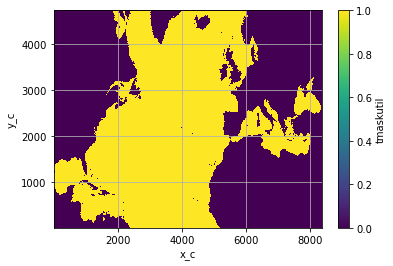

In [6]:
ds_tot

In [13]:
### First load zarr of corected vertical grid
ds_grz = xr.open_zarr(grid_path/zgrid_name)
ds_tot = ds_tot.merge(ds_grz.set_coords("hbot")).drop_vars("sossheig").unify_chunk()

CPU times: user 53min 40s, sys: 4min 56s, total: 58min 37s
Wall time: 58min 25s


In [ ]:
xgcm.Grid(ds_tot)

In [8]:
### load SSH, temperature and salinity: wrappers
dims = {"ssh": ("x_c", "y_c"), "temp":("x_c", "y_c", "z_c"), "salt":("x_c", "y_c", "z_c")}
dimap = {"x":"x_c", "y":"y_c", "deptht":"z_c"}
chks = ds.chunks

def get_var(path, varname):
    da = xr.open_zarr(path)[varname].squeeze()
    da = da.rename({dim:dimap[dim] for dim in da.dims})
    da = da.chunk({dim:chks[dim] for dim in da.dims})
    return da

In [9]:
### load and merge SSH, temperature and salinity
ds = ds.merge(get_var(mean_path/temp_fname, "votemper"), join="override") # get rid of depth
ds = ds.merge(get_var(mean_path/salt_fname, "vosaline"), join="override") # get rid of depth

print("dataset is {:.1f} GB".format(ds.nbytes/1e9))
ds

dataset is 392.1 GB


<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
    depth_c    (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    depth_l    (z_l) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    e3t        (z_c, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    e3w        (z_l, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    hbot       (y_c, x_c) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    sossheig   (y_c, x_c) float64 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    tmask      (z_c, y_c, x_c) int8 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    votemper   (z_c, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>
    vosaline   (z_c, y_c, x_c) float64 dask.array<chunksize=(10, 1200, 1200), meta=np.ndarray>

In [13]:
out_file

PosixPath('/scratch/cnt0024/ige2071/nlahaye/global_mean_bvf.zarr')

In [17]:
%%time
bvf = bvf2(ds).where(ds.tmaskutil).chunk({"z_l":10})
bvf.rename("bvf").to_dataset().to_zarr(out_file, mode="w")

KeyboardInterrupt: 

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/scratch/cnt0024/ige2071/nlahaye/conda38/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/scratch/cnt0024/ige2071/nlahaye/conda38/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/scratch/cnt0024/ige2071/nlahaye/conda38/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('open_dataset-ffc1b52436ae42a0fbf29768baf64723vosaline-bf7a2f424d4af1cf5e001035b0996562', 148, 0, 0)"
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WAR

### TODO:
* test on one chunk. Compute result to verify that we do not have nans
* run it, with to_zarr!

In [7]:
i_rng = slice(4014-1, 4134)
j_rng = slice(1438-1, 1576)

sds = ds_tot.isel(x_c=i_rng, x_r=i_rng, y_c=j_rng, y_r=j_rng)
sds

<xarray.Dataset>
Dimensions:     (x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/39)
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_r         (y_r) float64 1.438e+03 1.44e+03 ... 1.576e+03 1.576e+03
  * x_r         (x_r) float64 4.014e+03 4.016e+03 ... 4.134e+03 4.134e+03
    ...          ...
    fmask       (z_c, y_r, x_r) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    umaskutil   (y_c, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    vmaskutil   (y_r, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    fmaskutil   (y_r, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>

In [14]:
bvf = get_bvf(sds.where(sds.tmask))
bvf

<xarray.DataArray (z_l: 300, y_c: 139, x_c: 121, z_c: 300)>
dask.array<truediv, shape=(300, 139, 121, 300), dtype=float64, chunksize=(299, 139, 121, 300), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    ...          ...
    e2t         (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    e3w         (z_l, y_c, x_c, z_c) float64 dask.array<chunksize=(300, 139, 121, 300), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>

In [15]:
%%time
bvf.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-4f894727f809dc6298528c32540749c4', 0, 0)": ['tcp://127.0.0.1:44045'], "('getitem-a5d6a77a05891b093bf1ef3c7435f696', 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 1, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('mul-4df54b8136e8432cbd1a5a5767bd2950', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045']} state: ['waiting', 'waiting', 'waiting', 'waiting', 'waiting'] workers: ['tcp://127.0.0.1:44045']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:44045'], ('getitem-4f894727f809dc6298528c32540749c4', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promi

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
